In [130]:
#The code below was developed by Rodrigo A. Dourado, a PhD student at the University of Sao Paulo at São Carlos co-supervised 
#by Prof. J. Carlos Egues and Dr. Poliana H. Penteado. The results obtained via this code were also independently checked by additional 
#Mathematica and Python codes for particular cases developed by Dr Penteado.
#This code is not for distribution. 

In [131]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy import linalg as LA
import random
import numpy.matlib
import kwant
import tinyarray
import multiprocessing as mp
import os
from tqdm import tqdm


#pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [132]:
#The following function builds the system

def build_system(t, mu, mu_n, Delta, V_z, alpha, Ln, Lb, Ls, mu_leads, barrier_l, barrier_r):
    syst = kwant.Builder()
    a = 1
    lat = kwant.lattice.square(a, norbs=4)

    #lead
    sym_left_lead = kwant.TranslationalSymmetry((-a, 0))
    sym_right_lead = kwant.TranslationalSymmetry((a, 0))
    
    
    left_lead = kwant.Builder(sym_left_lead, conservation_law=np.diag([-2, -1, 1, 2])) 
    right_lead = kwant.Builder(sym_right_lead, conservation_law=np.diag([-2, -1, 1, 2])) 
    
    #print(f"left lead type: {type(left_lead)}")
    #print(f"right lead type: {type(right_lead)}")
    #print(f"syst type: {type(syst)}")
    

    #Here one can edit the chemical potential profile. The profile below is for the quasi-Majorana case, the pristine case would be 
    # mu_s[i] = mu, and for disorder we use mu_s[i] = mu + (some random value)
    # For the nontopological ABS (dotted magenta curve in Figs. 2 c and d), set alpha = 0 in the central region and add a 
    # Zeeman energy on the normal segments of the wire.
    
    mu_s = np.zeros(Ls)
    for i in range(Ls):
        mu_s[i] = mu #- (mu - mu_n) * (1 - np.tanh(i/80))    

    for i in range(Lb):
        syst[lat(i, 0)] = (2 * t - mu_n + barrier_l) * np.kron(sigma_z, sigma_0)
        if i > 0:
            syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y) 
    for i in range(Lb, Lb+Ln):
        syst[lat(i, 0)] = (2 * t - mu_n) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
    for i in range(Lb+Ln, Lb+Ln+Ls):
        syst[lat(i, 0)] = (2 * t - mu_s[i-Lb-Ln]) * np.kron(sigma_z, sigma_0) + Delta * np.kron(sigma_x, sigma_0) + V_z * np.kron(sigma_0, sigma_x)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
    for i in range(Lb+Ln+Ls, Lb+Ln+Ls+Ln):
        syst[lat(i, 0)] = (2 * t - mu_n) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y) 
    for i in range(Lb+Ln+Ls+Ln, Lb+Ln+Ls+Ln+Lb):
        syst[lat(i, 0)] = (2 * t - mu_n + barrier_r) * np.kron(sigma_z, sigma_0)
        syst[lat(i, 0), lat(i-1, 0)] = -t * np.kron(sigma_z, sigma_0) + 1j*alpha * np.kron(sigma_z, sigma_y)
    

    left_lead[lat(0, 0)] = (2 * t - mu_leads) * np.kron(sigma_z, sigma_0) 
    left_lead[lat(1, 0), lat(0, 0)] = -t * np.kron(sigma_z, sigma_0)
    right_lead[lat(0, 0)] = (2 * t - mu_leads) * np.kron(sigma_z, sigma_0) 
    right_lead[lat(1, 0), lat(0, 0)] = -t * np.kron(sigma_z, sigma_0)

    syst.attach_lead(left_lead)
    syst.attach_lead(right_lead)
    return syst.finalized()

In [133]:
#To generate Figs 1 and 2 one first sets the parameters

t = 102.0
mu = 1
mu_n = 0.2
mu_leads = 20.0
Delta = 0.5
alpha = 3.5
Ln = 20 # normal metal length
Lb = 4 #barrier length
Ls = 500 #super conductor length
V_c = np.sqrt(mu**2 + Delta**2)
V_z = 1.1* V_c # To generate Fig 2a V_z should be varied. For the cyan line in Fig 2, for example, V_z = 1.203 * V_c  
barrier_l = 5

points = 100
barrier_r = np.linspace(barrier_l, 40*barrier_l, points) #Varying the right barrier U_R

Andreev_downup = np.zeros(points)
Andreev_upup = np.zeros(points)
Andreev_updown = np.zeros(points)
Andreev_downdown = np.zeros(points)

conductance_left = np.zeros(points)
conductance_right = np.zeros(points)

for k in range(points):
    #print(f"running point: {k}/{points}")
    syst = build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=V_z, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier_l, barrier_r=barrier_r[k])
    smatrix = kwant.smatrix(syst, 0.0)
    #Calculating the conductance
    R = 0
    A = 0
    for i in range(2):
        for j in range(2):
            R = R + smatrix.transmission((0, j), (0, i))
            A = A + smatrix.transmission((0, j+2), (0, i))
    conductance_left[k] = 2 - R + A
    R = 0
    A = 0
    for i in range(2):
        for j in range(2):
            R = R + smatrix.transmission((1, j), (1, i))
            A = A + smatrix.transmission((1, j+2), (1, i))
    conductance_right[k] = 2 - R + A
    
    #Individual Andreev reflection components on the left side
    Andreev_downup[k] = smatrix.transmission((0, 2), (0, 0))
    Andreev_upup[k] = smatrix.transmission((0, 3), (0, 0))
    Andreev_downdown[k] = smatrix.transmission((0, 2), (0, 1))
    Andreev_updown[k] = smatrix.transmission((0, 3), (0, 1))

In [ ]:
### calculating ZBP using kwant
num_engs = 200
energies = np.linspace(-0.5, 0.5, num_engs)
dIdV_left = np.zeros_like(energies)
dIdV_right = np.zeros_like(energies)
ldos = np.zeros(shape = (num_engs, 2192))
#using symmetric barrier for now
syst = build_system(t=t, mu=mu, mu_n=mu_n, Delta=Delta, V_z=V_z, alpha=alpha, Ln=Ln, Lb=Lb, Ls=Ls, mu_leads=mu_leads, barrier_l=barrier_l, barrier_r=barrier_l)

for k, eng in tqdm(enumerate(energies), total=num_engs, desc="Calculating Conductance"):
    #print(f"running energy {k}/{num_engs}")
    eng = energies[k]
    smatrix = kwant.smatrix(syst, eng)
    R = 0
    A = 0
    for i in range(2):
        for j in range(2):
            R = R + smatrix.transmission((0, j), (0, i))
            A = A + smatrix.transmission((0, j+2), (0, i))
    dIdV_left[k] = 2 - R + A
    R = 0
    A = 0
    for i in range(2):
        for j in range(2):
            R = R + smatrix.transmission((1, j), (1, i))
            A = A + smatrix.transmission((1, j+2), (1, i))
    dIdV_right[k] = 2 - R + A
    
    ldos[k,:] = kwant.ldos(syst, eng)
    
   

Calculating Conductance: 100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


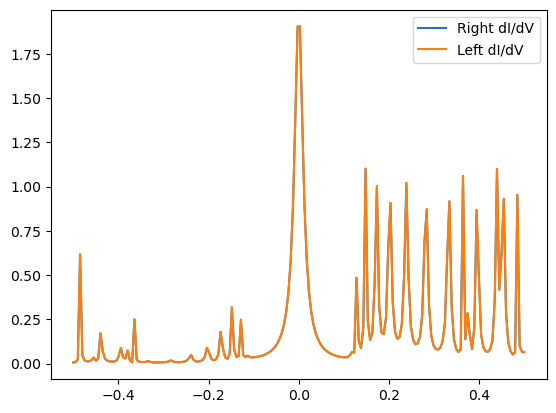

In [135]:
plt.plot(energies, dIdV_right, label = "Right dI/dV")
plt.plot(energies, dIdV_left, label = "Left dI/dV")
plt.legend()
    
    

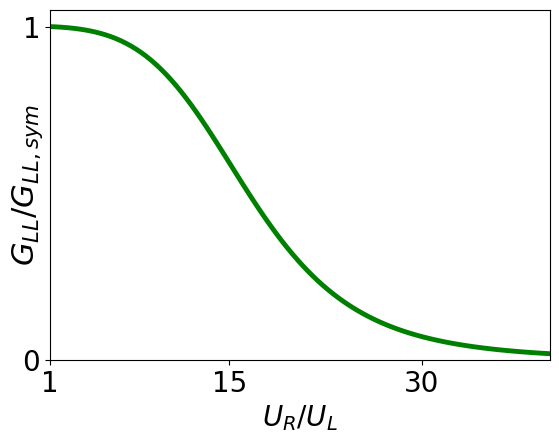

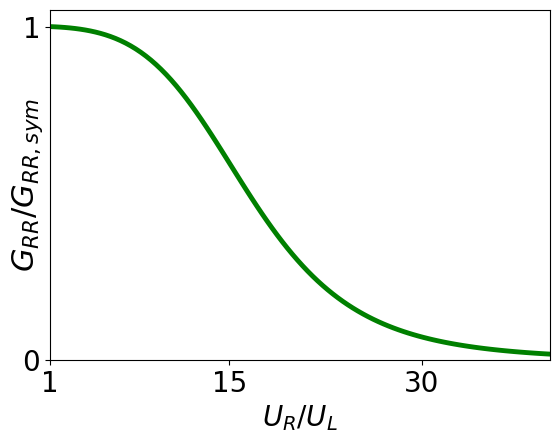

In [136]:
# This can be used to plot the many cases explored in Figs 1 and 2. 
# For Figs. 2a and 2b, one just needs to change the variables accordingly, barrier_r -> V_z and instead of the conductance 
# plot the Andreev reflection components calculated above

fig, axes = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(0,0,1,1)

lw = 3.5

axes.plot(barrier_r, conductance_left/conductance_left[0], color="green", linewidth=lw)
axes.set_xlim(barrier_r[0], barrier_r[-1])
axes.set_ylim(0, 1.05)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)
axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
axes.set_xticklabels([1, 15, 30], fontsize=20)
axes.set_xlabel(r"$U_{R}/U_{L} $", fontsize=20)
axes.set_ylabel(r"$G_{LL}/G_{LL, sym}$", fontsize=22)
axes.yaxis.set_label_coords(-0.01, 0.5)

fig, axes = plt.subplots(1,1, figsize=(5,3.5))
fig.subplots_adjust(0,0,1,1)

axes.plot(barrier_r, conductance_right/conductance_right[0], color="green", linewidth=lw)
axes.set_xlim(barrier_r[0], barrier_r[-1])
axes.set_ylim(0, 1.05)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)
axes.set_xticks([barrier_l, 15*barrier_l, 30*barrier_l])
axes.set_xticklabels([1, 15, 30], fontsize=20)
axes.set_xlabel(r"$U_{R}/U_{L}$", fontsize=20)
axes.set_ylabel(r"$G_{RR}/G_{RR, sym}$", fontsize=22)
axes.yaxis.set_label_coords(-0.01, 0.5)

In [137]:

## playing with a way to quantify the correlation above. 
##Integrating the areas and taking a normalized difference seems to be working so far.

normcond_R = conductance_right/conductance_right[0]
normcond_L = conductance_left/conductance_left[0]

Area_R = np.trapz(normcond_R)
Area_L = np.trapz(normcond_L)

np.abs(Area_R - Area_L)/(Area_R + Area_L)




0.0008222240774953012

In [12]:
# For Fig 3 we want to precisely control the couplings to the leads, so we use GF instead. 
# The LDOS was also compared to the one obtained via KWANT and both results agree. 
# First one should build H again

def build_H(mu, t, Delta, alpha, Vz, N):

    H = np.zeros([4*N, 4*N])

    for i in range(N):

        H[4*i][4*i] = 2*t - mu
        H[4*i + 1][4*i + 1] = 2*t - mu
        H[4*i + 2][4*i + 2] = -(2*t - mu)
        H[4*i + 3][4*i + 3] = -(2*t - mu)

        H[4*i][4*i + 1] = Vz
        H[4*i + 1][4*i] = Vz
        H[4*i + 2][4*i + 3] = Vz
        H[4*i + 3][4*i + 2] = Vz

        H[4*i][4*i + 2] = Delta
        H[4*i + 1][4*i + 3] = Delta
        H[4*i + 2][4*i] = Delta
        H[4*i + 3][4*i + 1] = Delta

        if i < N-1:

            H[4*i][4*i + 4] = -t
            H[4*i + 1][4*i + 4 + 1] = -t
            H[4*i + 2][4*i + 4 + 2] = t
            H[4*i + 3][4*i + 4 + 3] = t

            H[4*i][4*i + 4 + 1] = alpha
            H[4*i + 1][4*i + 4] = -alpha
            H[4*i + 2][4*i + 4 + 3] = -alpha
            H[4*i + 3][4*i + 4 + 2] = alpha

            H[4*i + 4][4*i] = -t
            H[4*i + 4 + 1][4*i + 1] = -t
            H[4*i + 4 + 2][4*i + 2] = t
            H[4*i + 4 + 3][4*i + 3] = t

            H[4*i + 4][4*i + 1] = -alpha
            H[4*i + 4 + 1][4*i] = alpha
            H[4*i + 4 + 2][4*i + 3] = alpha
            H[4*i + 4 + 3][4*i + 2] = -alpha

    return H

In [13]:
N = 500 
mu = 1
Delta = 0.5 
alpha = 3.5
V_c = np.sqrt(mu**2 + Delta**2)
Vz = 1.4 * V_c
t = 102 

nu1 = 0.5
nu2 = 0.75
nu3 = 0.95

H = np.matrix( build_H(mu=mu, t=t, Delta=Delta, alpha=alpha, Vz=Vz, N=N) )
eig_e, eig_v = LA.eigh(H)

Gamma_L = 0.5 * Delta
eta = 10**(-8)
Gamma_R = Gamma_L # To have a reference point, one starts with symmetric couplings

self_E = np.matrix( np.zeros([4*N, 4*N], dtype=complex) )

self_E[0,0] = -1j*Gamma_L/2
self_E[1,1] = -1j*Gamma_L/2
self_E[2,2] = -1j*Gamma_L/2
self_E[3,3] = -1j*Gamma_L/2

self_E[4*N - 4, 4*N - 4] = -1j*Gamma_R/2
self_E[4*N - 3, 4*N - 3] = -1j*Gamma_R/2
self_E[4*N - 2, 4*N - 2] = -1j*Gamma_R/2
self_E[4*N - 1, 4*N - 1] = -1j*Gamma_R/2

G = np.matrix( LA.inv( np.matrix( 1j*eta*np.identity(4*N) - H - self_E ) ) ) # \eta makes the matrix non singular

A = 1j*(G - G.getH())
LDOS_sym = np.zeros([N])

for i in range(N):
    for j in range(4):
        LDOS_sym[i] = LDOS_sym[i] + (A[4*i + j, 4*i + j] ).real
    LDOS_sym[i] =  ( 0.5/(2*np.pi) ) * LDOS_sym[i]
    
normalizing = np.max(LDOS_sym)
LDOS_sym = LDOS_sym/normalizing


def obtain_ldos(H, Gamma_L, Gamma_R, normalizing, E):
    self_En = np.zeros([4*N, 4*N], dtype=complex)
    self_En[0,0] = -1j*Gamma_L/2
    self_En[1,1] = -1j*Gamma_L/2
    self_En[2,2] = -1j*Gamma_L/2
    self_En[3,3] = -1j*Gamma_L/2

    self_En[4*N - 4, 4*N - 4] = -1j*Gamma_R/2
    self_En[4*N - 3, 4*N - 3] = -1j*Gamma_R/2
    self_En[4*N - 2, 4*N - 2] = -1j*Gamma_R/2
    self_En[4*N - 1, 4*N - 1] = -1j*Gamma_R/2

    G = np.matrix( LA.inv( np.matrix( (E+1j*eta)*np.identity(4*N) - H - self_En ) ) ) 

    A = 1j*(G - G.getH())
    LDOS = np.zeros([N])
    for i in range(N):
        for j in range(4):
            LDOS[i] = LDOS[i] + (A[4*i + j, 4*i + j] ).real
        LDOS[i] =  ( 0.5/(2*np.pi) ) * LDOS[i]

    LDOS = LDOS/normalizing

    return LDOS

LDOS2 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu1)*Gamma_L/(1+nu1), normalizing=normalizing, E = 0)
LDOS3 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu2)*Gamma_L/(1+nu2), normalizing=normalizing, E = 0)
LDOS4 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu3)*Gamma_L/(1+nu3), normalizing=normalizing, E = 0)

# The conductance (below) in the inset of Fig. 3b is calculated analytically [Eq. (S15), SM]. 

em = eig_e[2*N]
points = 1001
E = np.linspace(-10*em, 10*em, points)
G = np.zeros(points)
G1 = np.zeros(points)
G2 = np.zeros(points)
G3 = np.zeros(points)

def conductance(Gamma_L, em, nu, E):
    Gamma_R = (1-nu)*Gamma_L/(1+nu)
    Gamma = 0.5 * (Gamma_L + Gamma_R)
    gamma0 = 0.5 * (Gamma_L - Gamma_R)
    ta = (1j*(Gamma+gamma0)*2*E -(Gamma*Gamma - gamma0*gamma0))/(4*(em*em - E*E)-1j*4*E*Gamma + Gamma*Gamma - gamma0*gamma0 )
    td = (0.5*em*np.sqrt(Gamma*Gamma - gamma0*gamma0)  )/(4*(em*em - E*E)-1j*4*E*Gamma + Gamma*Gamma - gamma0*gamma0 )
    return 2*ta*np.conj(ta)+ 2*td*np.conj(td) 

for i in range(points): # sweeping the energy
    G[i] = conductance(Gamma_L=0.0025*Gamma_L, em=em, nu=0, E=E[i]).real
    G1[i] = conductance(Gamma_L=0.0025*Gamma_L, em=em, nu=nu1, E=E[i]).real
    G2[i] = conductance(Gamma_L=0.0025*Gamma_L, em=em, nu=nu2, E=E[i]).real
    G3[i] = conductance(Gamma_L=0.0025*Gamma_L, em=em, nu=nu3, E=E[i]).real

[Text(-0.0014280260053091557, 0, '$-5 \\epsilon_m$'),
 Text(0.0, 0, '0'),
 Text(0.0014280260053091557, 0, '$5 \\epsilon_m$')]

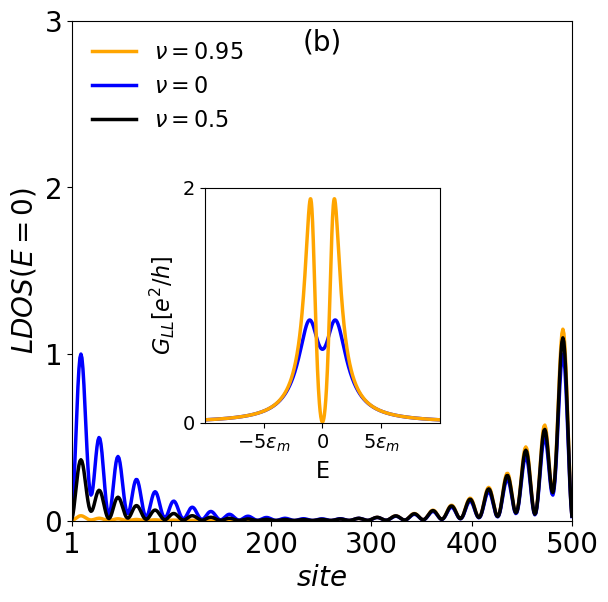

In [14]:
#Plotting Fig 3b

sites = np.linspace(1, N, N)

fig, axes = plt.subplots(1,1, figsize=(5,5))
fig.subplots_adjust(0,0,1,1)

lw = 2.5
axes.plot(sites, LDOS4, label=r"$\nu = 0.95 $", color='orange', linewidth=lw)
axes.plot(sites, LDOS_sym, label=r"$\nu = 0 $", color='blue', linewidth=lw)
axes.plot(sites, LDOS2, label=r"$\nu = 0.5$", color='black', linewidth=lw)
axes.set_xlim(0.99, N+0.01)
axes.set_ylim(0, 1.02*np.max(LDOS4))
axes.set_xlabel(r"$site$", fontsize=20)
axes.legend(loc=2, fontsize=16, frameon=False)
axes.set_ylabel(r"$LDOS (E=0)$", fontsize=20)
axes.set_yticks([0, 1, 2, 3])
axes.set_yticklabels([0, 1, 2, 3], fontsize=20)
axes.set_xticks([1, 100, 200, 300, 400, 500])
axes.set_xticklabels([1, 100, 200, 300, 400, 500], fontsize=20)
axes.set_title('(b)', fontsize=20, y=0.98, pad=-14)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(axes, 2.35,2.35, loc=1, bbox_to_anchor=(0.75, 0.68),bbox_transform=axes.figure.transFigure)

axins.plot(E, G, label=r'$\gamma_0 = 0$', color="blue", linewidth=2.5)
#axins.plot(E, G1, label=r'$\gamma_0 = 0.35 \Gamma$', color='orange', linestyle='dashed')
#axins.plot(E, G2, label=r'$\gamma_0 = 0.75 \Gamma$', color='green')
axins.plot(E, G3, label=r'$\gamma_0 = 0.95 \Gamma$', color='orange', linewidth=2.5)
axins.set_xlabel('E', fontsize=16)
axins.set_ylabel(r'$G_{LL} [e^2/h]$', fontsize=16)
axins.set_xlim(E[0], E[-1])
axins.set_ylim(0, 1.01)
axins.set_yticks([0, 2])
axins.set_yticklabels([0, 2], fontsize=14)
axins.set_xticks([-5*em, 0, 5*em])
axins.set_xticklabels([r'$-5 \epsilon_m$', r'0', r'$5 \epsilon_m$'], fontsize=14)

In [15]:
points = 10
E = np.linspace(-2*eig_e[2*N], 2*eig_e[2*N], points) #sweeping the energies
LDOS1 = np.zeros([points, N+1])
LDOS2 = np.zeros([points, N+1])
LDOS3 = np.zeros([points, N+1])
LDOS4 = np.zeros([points, N+1])

for j in range(points):
    print(f"Calculating point {j}/{points}")
    LDOS_a = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=Gamma_L, normalizing=normalizing, E=E[j])
    for i in range(N):
        LDOS1[j][i] = LDOS_a[i]
    LDOS_a = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu1)*Gamma_L/(1+nu1), normalizing=normalizing, E=E[j])
    for i in range(N):
        LDOS2[j][i] = LDOS_a[i]
    LDOS_a = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu2)*Gamma_L/(1+nu2), normalizing=normalizing, E=E[j])
    for i in range(N):
        LDOS3[j][i] = LDOS_a[i]
    LDOS_a = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu3)*Gamma_L/(1+nu3), normalizing=normalizing, E=E[j])
    for i in range(N):
        LDOS4[j][i] = LDOS_a[i]
        
LDOS1[0][N] = np.max(LDOS4)
LDOS2[0][N] = np.max(LDOS4)
LDOS3[0][N] = np.max(LDOS4) 

Calculating point 0/10
Calculating point 1/10
Calculating point 2/10
Calculating point 3/10
Calculating point 4/10
Calculating point 5/10
Calculating point 6/10
Calculating point 7/10
Calculating point 8/10
Calculating point 9/10


In [ ]:
####### Copy of above cell but in parallel
points = 51

def calculate_ldos_for_energy(energy_value):
    """
    Performs the LDOS calculations for a single energy value.
    This is the function that will be run in parallel on different cores.
    """
    
    # Each call to obtain_ldos is performed for the given energy_value
    ldos1 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=Gamma_L, normalizing=normalizing, E=energy_value)
    ldos2 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu1)*Gamma_L/(1+nu1), normalizing=normalizing, E=energy_value)
    ldos3 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu2)*Gamma_L/(1+nu2), normalizing=normalizing, E=energy_value)
    ldos4 = obtain_ldos(H=H, Gamma_L=Gamma_L, Gamma_R=(1-nu3)*Gamma_L/(1+nu3), normalizing=normalizing, E=energy_value)
    
    # Return the results for this single energy point as a tuple
    return ldos1, ldos2, ldos3, ldos4


E = np.linspace(-2*eig_e[2*N], 2*eig_e[2*N], points) #sweeping the energies

num_processes = os.cpu_count() -2
print(f"Starting parallel calculation on {num_processes} cores...")
results = []
with mp.Pool(processes=num_processes) as pool:
    for result in tqdm(pool.imap(calculate_ldos_for_energy, E), total=len(E)):
        results.append(result)
    
LDOS1 = np.zeros([points, N+1])
LDOS2 = np.zeros([points, N+1])
LDOS3 = np.zeros([points, N+1])
LDOS4 = np.zeros([points, N+1])

for j, (r1, r2, r3, r4) in enumerate(results):
    LDOS1[j, :N] = r1
    LDOS2[j, :N] = r2
    LDOS3[j, :N] = r3
    LDOS4[j, :N] = r4
    
# Final calculations (same as your original code)
max_val = np.max(LDOS4)
LDOS1[0, N] = max_val
LDOS2[0, N] = max_val
LDOS3[0, N] = max_val

print("Parallel calculation finished.")

Text(0, 0.5, 'LDOS')

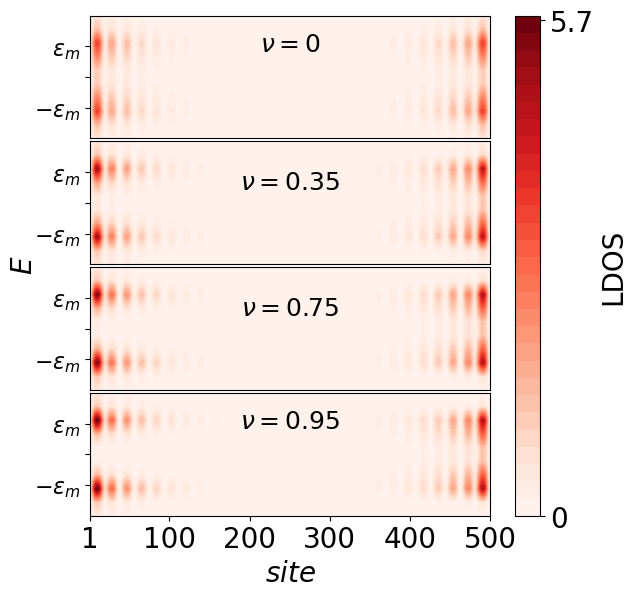

In [16]:
#Plotting Fig 3a

sites = np.linspace(1, N+1, N+1)
X,Y = np.meshgrid(sites, E)
Z1 = LDOS1
Z2 = LDOS2
Z3 = LDOS3
Z4 = LDOS4

em = eig_e[2*N]
ncolors = 30

mycmap1 = plt.get_cmap('Reds')

fig, axes = plt.subplots(4,1, figsize=(5,5))
fig.subplots_adjust(0,0,1,1)
fig.subplots_adjust(wspace=0.0, hspace=0.025)

contourFigure = axes[0].contourf(X, Y, Z1, ncolors, cmap=mycmap1)
axes[0].set_title(r"$\nu = 0$", fontsize=18, y=0.8, va="top")
axes[0].set_xlim(sites[0], sites[N-1])
axes[0].set_xticks([])
axes[0].set_yticks([-em, 0, em])
axes[0].set_yticklabels([r"$-\epsilon_m$", '', r"$\epsilon_m$"], fontsize=16)

contourFigure = axes[1].contourf(X, Y, Z2, ncolors, cmap=mycmap1)
axes[1].set_title(r"$\nu = 0.35$", fontsize=18, y=0.7, va="top")
axes[1].set_xlim(sites[0], sites[N-1])
axes[1].set_xticks([])
axes[1].set_yticks([-em, 0, em])
axes[1].set_yticklabels([r"$-\epsilon_m$", '', r"$\epsilon_m$"], fontsize=16)

contourFigure = axes[2].contourf(X, Y, Z3, ncolors, cmap=mycmap1)
axes[2].set_title(r"$\nu = 0.75$", fontsize=18, y=0.7, va="top")
axes[2].set_xticks([])
axes[2].set_xlim(sites[0], sites[N-1])
axes[2].set_yticks([-em, 0, em])
axes[2].set_yticklabels([r"$-\epsilon_m$", '',r"$\epsilon_m$"], fontsize=16)

contourFigure = axes[3].contourf(X, Y, Z4, ncolors, cmap=mycmap1)
axes[3].set_title(r"$\nu = 0.95$", fontsize=18, y=0.8, va="top")
axes[3].set_xlim(sites[0], sites[N-1])
axes[3].set_xlabel(r"$site$", fontsize=20)
axes[3].set_ylabel(r"$E$", fontsize=20)
axes[3].yaxis.set_label_coords(-0.13, 2.05)
axes[3].set_yticks([-em, 0, em])
axes[3].set_yticklabels([r"$-\epsilon_m$", '',r"$\epsilon_m$"], fontsize=16)
axes[3].set_xticks([1, 100, 200, 300, 400, 500])
axes[3].set_xticklabels([1, 100, 200, 300, 400, 500], fontsize=20)

cbar=fig.colorbar(contourFigure, ax=axes, ticks=[0, np.max(LDOS4)])
cbar.ax.set_yticklabels(['0', '%.1f' % np.max(LDOS4)], fontsize=20)
cbar.ax.set_ylabel('LDOS', fontsize=20)

In [17]:
#For fig 4b, we use the effective model. We have analytical expressions for the conductance and the LDOS of the dot

#Parameters
E_d = 20
em = 0.00375
Gamma_L = 100 * em
t_0 = Gamma_L

points = 1001
E = np.linspace(- 1.5 * em, 1.5 * em, points)

eta = 10**(-15)
Gamma_R_1 = 0
Gamma_R_2 = 0.002 * Gamma_L
Gamma_R_3 = 0.2*Gamma_L
Gamma_R_4 = Gamma_L

DOS1 = np.zeros(points)
DOS2 = np.zeros(points)
DOS3 = np.zeros(points)
DOS4 = np.zeros(points)

def obtain_dos(Gamma_R, Gamma_L, t_0, em, E, points, eta):

    DOS = np.zeros(points)
    for j in range(points):
        G_inv = np.zeros([4, 4], dtype=complex)
        G_inv[0][0] = E[j] + 1j * eta - E_d + 1j * Gamma_L
        G_inv[1][1] = E[j] + 1j * eta + E_d + 1j * Gamma_L
        G_inv[2][2] = E[j] + 1j * eta
        G_inv[0][2] = -t_0
        G_inv[1][2] = t_0
        G_inv[2][0] = -t_0
        G_inv[2][1] = t_0
        G_inv[2][3] = -1j * em 
        G_inv[3][2] = 1j * em 

        G_inv[3][3] = E[j] + 1j * eta + 1j * Gamma_R #Here you can set E = 0 and vary Gamma_R
        G = np.matrix( LA.inv(G_inv) )
        DOS[j] = -0.5 * (G[0, 0].imag + G[1, 1].imag)
    return DOS

DOS1 = obtain_dos(Gamma_R=Gamma_R_1, Gamma_L=Gamma_L, t_0=t_0, em=em, E=E, points=points, eta=eta)
DOS2 = obtain_dos(Gamma_R=Gamma_R_2, Gamma_L=Gamma_L, t_0=t_0, em=em, E=E, points=points, eta=eta)
DOS3 = obtain_dos(Gamma_R=Gamma_R_3, Gamma_L=Gamma_L, t_0=t_0, em=em, E=E, points=points, eta=eta)
DOS4 = obtain_dos(Gamma_R=Gamma_R_4, Gamma_L=Gamma_L, t_0=t_0, em=em, E=E, points=points, eta=eta)

#For fig 4c you set E = 0 and sweep Gamma_R instead

[Text(0, 0, '0'), Text(0, 1, '1')]

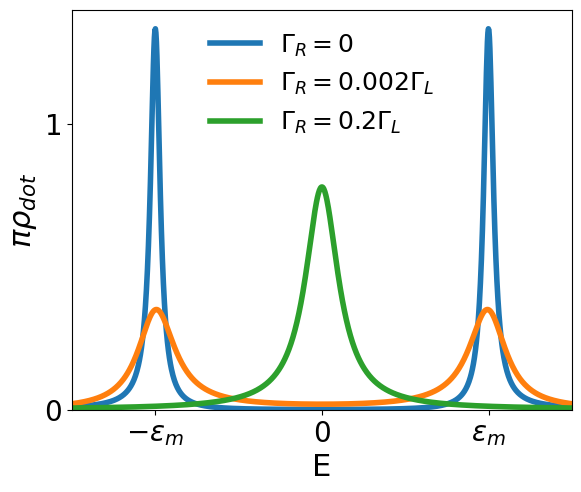

In [18]:
# Fig. 4c

fig, axes = plt.subplots(1,1, figsize=(5,4))
fig.subplots_adjust(0,0,1,1)

axes.plot(E, DOS1, label=r'$\Gamma_R = 0$',linewidth=4)
axes.plot(E, DOS2, label=r'$\Gamma_R = 0.002 \Gamma_L$',linewidth=4)
axes.plot(E, DOS3, label=r'$\Gamma_R = 0.2 \Gamma_L$',linewidth=4)
axes.set_xlim(E[0], E[-1])
axes.set_ylim(0, 1.05*max(np.max(DOS1), np.max(DOS2), np.max(DOS3)))
axes.set_xticks([-em, 0, em])
axes.set_xticklabels([r'$-\epsilon_m$', '0', r'$\epsilon_m$'], fontsize=20)
axes.set_xlabel('E', fontsize=22)
axes.set_ylabel(r'$\pi\rho_{dot}$', fontsize=22)
axes.legend(loc=9, frameon=False, fontsize=18)
axes.set_yticks([0, 1])
axes.set_yticklabels([0, 1], fontsize=20)